In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
from PIL import Image
import seaborn as sb
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import urllib
#------------------
from dataset import RandomTestDataset
from models import MLP
from resnet_family import resnet20_cifar
from utils_cm import compute_cm

## Softmax probabilites vs model uncertainty

Softmax gives you a notion of confidence for choosing a class over other classes known to the network. 
It does NOT provide you with the uncertainty of the model.

## Evaluate the confidence of the model on unseen categories

In [2]:
# image = image.resize((32, 32))
transform = transforms.Compose([transforms.Resize((32, 32)), 
                                       transforms.ToTensor(), 
                                       transforms.Normalize(mean=[0.491, 0.482, 0.446], std=[0.247, 0.243, 0.261])])
seen_classes = RandomTestDataset('./images/seen_cifar10', transform=transform)
unseen_classes = RandomTestDataset('./images/unseen_cifar10', transform=transform)
seen_dataloader = DataLoader(seen_classes, batch_size=1, shuffle=False)
unseen_dataloader = DataLoader(unseen_classes, batch_size=1, shuffle=False)

In [3]:
labels_cifar10 = ['airplanes', 'cars', 'birds', 'cats', 'deer', 'dogs', 'frogs', 'horses', 'ships', 'trucks']

model = resnet20_cifar()
model.eval()

seen = []
unseen = []

for i_iter, batch in enumerate(seen_dataloader):
    image, file_name = batch
    output = model(image)
    score, label = F.softmax(output, dim=1).max(1)
    full_file_name = os.path.join('./images/seen_cifar10', file_name[0])
    seen.append({'fname': full_file_name, 'prediction': labels_cifar10[label], 'score': np.round(score.item(), 3)})
    
for i_iter, batch in enumerate(unseen_dataloader):
    image, file_name = batch
    output = model(image)
    score, label = F.softmax(output, dim=1).max(1)
    full_file_name = os.path.join('./images/unseen_cifar10', file_name[0])
    unseen.append({'fname': full_file_name, 'prediction': labels_cifar10[label], 'score': np.round(score.item(), 3)})

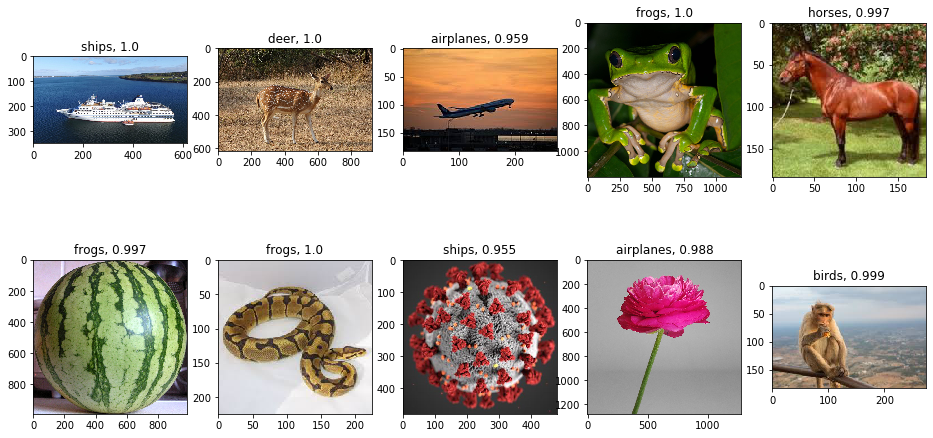

In [4]:
fig, ax = plt.subplots(2, 5, figsize=(16, 8))
for i in range(len(seen)):
    image = Image.open(seen[i]['fname'])
    ax[0, i].imshow(image)
    ax[0, i].set_title(f"{seen[i]['prediction']}, {seen[i]['score']}")
    image = Image.open(unseen[i]['fname'])
    ax[1, i].imshow(image)
    ax[1, i].set_title(f"{unseen[i]['prediction']}, {unseen[i]['score']}")

# Model Uncertainty

The idea of computing model uncertainty is to find out what the model does Not know. Then we should be more hesitant making decisions on thoses cases. As an example, when you train a machine learning model using either Maximum-Likelihood or Maximum-a-Posteriory algorithm, you end up with a point estimate for the model parameters $\theta^*$. This leads to a fixed leanred model $h(\theta^*)$, that always maps an input sample $x_0$ to $y_0 = h(x_0; \theta^*)$. 

What if for a reason (for example staying on a saddle point in the parameters space) that mapping is not reliable and the model is very sensitive to small deviations of the input data? What might happen is that we might get $y_1 = h(x_1; \theta^*)$ , where $y_1$ is far off from $y_0$, despite the fact that $\|x_1 - x_0\| < \epsilon$.

This is where embedding prior knowledge into the models (most commonly using Bayesian Learning/Inference) comes into play. The idea of Bayesian learning is to account for different possibilities for the model parameters rather than relying on some point estimates weights (which are offsprings of the MLE/MAP algorithms). These different possibilities are normally encoded using prior knowledge that is bound to the model parameters/weight. They are often defined as prior distributions over the parameters and used during model training, and then at the inference time, a set of parameters are sampled from their pre-definde distributions and used for making predictions.

A natural extension of using Bayesian inference is thatthe models learned this way can be seamlessly used for ensemble predictions; I.e no extra training is required to produce multiple models, you just run the model with different prior samplings and get slightly different results, which is what proposed in this paper [YarinGalEtal-2016](http://proceedings.mlr.press/v48/gal16.pdf). 

Another advantage of Bayesian learning is that we don't need to worry that much about hyper-parameter optimisation and the state of the weights when training stops, because at the inference time we just integrate over the entire distribution of the parameters. This however is computationally interactable and we almost always would need to settle with approximate inference.

## Gaussian Processes, Bayesian Optimisation, and Bayesian NNs using DropOut

### Good reads (and watch):
[A Tutorial on Bayesian Optimization of Expensive Cost Functions](docs/BayesianOptimisation.pdf)

[What My Deep Model Doesn't Know](http://mlg.eng.cam.ac.uk/yarin/blog_3d801aa532c1ce.html)

[Leveraging uncertainty information from deep neural networks for disease detection](docs/BayesianDNN_nature_eye_disease.pdf)

[Bayesian CNNs](https://arxiv.org/pdf/1506.02158.pdf)

[Uncertainty Quantification and Deep Learning, Elise Jennings](https://www.youtube.com/watch?v=Puc_ujh5QZs)

### Resemblance of Bayesian Neural networks and Gaussian Processes

A single layer wide neural network with infinite number of neurons and probability distributions over the weights is mathematically equivalent to a Gaussian Process [Priors for Infinite Networks](https://www.cs.toronto.edu/~radford/ftp/pin.pdf), [Deep Neural Networks as Gaussian Processes](https://openreview.net/pdf?id=B1EA-M-0Z).

## Experiments on MNIST

We build a shallow network and test it in MNST data, and run some experiments similar to what shown in [here](http://mlg.eng.cam.ac.uk/yarin/blog_3d801aa532c1ce.html) and [here](https://xuwd11.github.io/Dropout_Tutorial_in_PyTorch/).

### Preparing the dataset

In [5]:
batch_size = 64
mnist_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
# Train Set:
mnist_train_dataset = torchvision.datasets.MNIST('./data/', train=True, download=True, transform=mnist_transform)
mnist_train_loader = DataLoader(mnist_train_dataset, batch_size=batch_size, shuffle=True)
# Test Set:
mnist_test_dataset = torchvision.datasets.MNIST('./data/', train=False, download=True, transform=mnist_transform)
mnist_test_loader = DataLoader(mnist_test_dataset, batch_size=batch_size, shuffle=False)

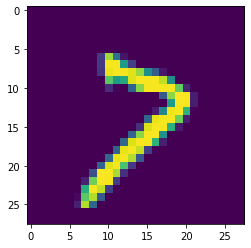

In [6]:
sample_data = next(enumerate(mnist_train_loader))
sample_data = sample_data[1][0].view(batch_size, 784)[0, :].view(28, 28).data.numpy()
plt.imshow(sample_data)

### Build the model (without DropOut) and configure the training

In [7]:
mlp = MLP(input_size=28*28, nclasses=10, hidden_layers=[800, 800], dropout=0, dropout_input=0)
optimizer = torch.optim.SGD(mlp.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
mlp.net

Sequential(
  (0): Linear(in_features=784, out_features=800, bias=True)
  (1): ReLU6()
  (2): Linear(in_features=800, out_features=800, bias=True)
  (3): ReLU6()
  (4): Linear(in_features=800, out_features=10, bias=True)
)

In [8]:
n_epochs = 10
loss_value = 0
reset_loss_every = 300
device = "cpu"

In [9]:
for epoch in range(n_epochs):
    for it, train_batch in enumerate(mnist_train_loader):
        mlp.train()
        
        images, train_labels_batch = train_batch
        train_data_batch = images.view(train_labels_batch.shape[0], 784)
        output = mlp(train_data_batch)
        optimizer.zero_grad()
        loss = F.cross_entropy(output, train_labels_batch.to(device), reduction="mean")
        
        loss.backward()
        loss_value += loss.item()
        optimizer.step()
        
        if (it % reset_loss_every) == 0 and it > 0:
            print(f"epoch: {epoch}, iteration: {it}, loss_value: {loss_value/reset_loss_every}")
            loss_value = 0

epoch: 0, iteration: 300, loss_value: 0.499298428495725
epoch: 0, iteration: 600, loss_value: 0.20559136313696702
epoch: 0, iteration: 900, loss_value: 0.14985535636544228
epoch: 1, iteration: 300, loss_value: 0.12164156019066771
epoch: 1, iteration: 600, loss_value: 0.09641085763151447
epoch: 1, iteration: 900, loss_value: 0.08959421917796134
epoch: 2, iteration: 300, loss_value: 0.06895608865966399
epoch: 2, iteration: 600, loss_value: 0.06182547238500168
epoch: 2, iteration: 900, loss_value: 0.06839684196126958
epoch: 3, iteration: 300, loss_value: 0.04956956620017688
epoch: 3, iteration: 600, loss_value: 0.04473136400338262
epoch: 3, iteration: 900, loss_value: 0.048136376794427636
epoch: 4, iteration: 300, loss_value: 0.038423859155736866
epoch: 4, iteration: 600, loss_value: 0.03409948660526425
epoch: 4, iteration: 900, loss_value: 0.033871883979688086
epoch: 5, iteration: 300, loss_value: 0.026381672898617883
epoch: 5, iteration: 600, loss_value: 0.025477628266283622
epoch: 5, i

### Evaluating on the test set

In [10]:
mlp.eval()
gt_test, preds_test = [], []
for it_test, test_batch in enumerate(mnist_test_loader):
    images, test_labels_batch = test_batch
    test_data_batch = images.view(test_labels_batch.shape[0], 784)
    output_test = mlp(test_data_batch.to(device).float())
    preds_test.append(F.softmax(output_test, dim=1).data.numpy())
    gt_test.append(test_labels_batch.numpy())
preds_test = np.vstack(preds_test)
preds_test_labels = preds_test.argmax(-1)
preds_test_score = preds_test.max(-1)
gt_test = np.hstack(gt_test)
recall, precision = compute_cm(gt_test, preds_test_labels, classes=range(10))
print(f'average recall: {recall.mean()},  average precision: {precision.mean()}')
preds_test.shape

average recall: 0.982,  average precision: 0.983


(10000, 10)

### Filter the incorrectly classified images

In [11]:
preds_test_score_threshold = 0.5
wrong_samples = np.where(np.logical_and(gt_test != preds_test_labels, preds_test_score > preds_test_score_threshold))[0]
wrong_samples_labels = preds_test_labels[wrong_samples]
wrong_samples_scores = preds_test_score[wrong_samples]
wrong_samples_gt = gt_test[wrong_samples]
wrong_samples_gt

array([4, 4, 2, 5, 6, 3, 8, 8, 1, 2, 2, 7, 5, 9, 1, 8, 5, 6, 6, 6, 4, 7,
       4, 6, 7, 2, 7, 9, 4, 9, 7, 8, 7, 5, 2, 7, 8, 4, 2, 0, 6, 2, 3, 8,
       2, 8, 9, 5, 6, 2, 0, 7, 5, 4, 7, 3, 4, 6, 1, 8, 9, 9, 6, 2, 5, 9,
       6, 9, 4, 8, 3, 3, 9, 3, 1, 5, 7, 8, 7, 4, 6, 9, 6, 5, 9, 8, 4, 2,
       7, 2, 0, 5, 1, 9, 4, 9, 0, 9, 9, 2, 7, 1, 5, 2, 8, 9, 6, 7, 8, 7,
       8, 4, 0, 2, 1, 1, 4, 3, 7, 4, 5, 3, 5, 3, 3, 9, 8, 9, 7, 0, 9, 1,
       6, 2, 6, 0, 8, 8, 4, 7, 7, 7, 7, 9, 0, 6, 5, 4, 5, 2, 5, 9, 2, 3])

In [12]:
wrong_subset = torch.utils.data.Subset(mnist_test_dataset, wrong_samples)
wrong_subset_loader = DataLoader(wrong_subset, batch_size=1, shuffle=False)

### And some correct ones

In [13]:
preds_test_score_threshold = 0.5
right_samples = np.where(np.logical_and(gt_test == preds_test_labels, preds_test_score > preds_test_score_threshold))[0]
right_samples_labels = preds_test_labels[right_samples]
right_samples_scores = preds_test_score[right_samples]
right_samples_gt = gt_test[right_samples]
right_samples_gt

array([7, 2, 1, ..., 4, 5, 6])

In [14]:
right_subset = torch.utils.data.Subset(mnist_test_dataset, right_samples)
right_subset_loader = DataLoader(right_subset, batch_size=1, shuffle=False)

## Re-evaluate those images, but with active DropOut 

### First re-train the model, with DropOut enabled.

In [15]:
mlp_dropout = MLP(input_size=28*28, nclasses=10, hidden_layers=[800, 800], dropout=0.5, dropout_input=0.2)
optimizer = torch.optim.SGD(mlp_dropout.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
mlp_dropout.net

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=784, out_features=800, bias=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): ReLU6()
  (4): Linear(in_features=800, out_features=800, bias=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): ReLU6()
  (7): Linear(in_features=800, out_features=10, bias=True)
)

In [16]:
n_epochs = 10
loss_value = 0
reset_loss_every = 300
device = "cpu"

for epoch in range(n_epochs):
    for it, train_batch in enumerate(mnist_train_loader):
        mlp_dropout.train()
        
        images, train_labels_batch = train_batch
        train_data_batch = images.view(train_labels_batch.shape[0], 784)
        output = mlp_dropout(train_data_batch)
        optimizer.zero_grad()
        loss = F.cross_entropy(output, train_labels_batch.to(device), reduction="mean")
        
        loss.backward()
        loss_value += loss.item()
        optimizer.step()
        
        if (it % reset_loss_every) == 0 and it > 0:
            print(f"epoch: {epoch}, iteration: {it}, loss_value: {loss_value/reset_loss_every}")
            loss_value = 0

epoch: 0, iteration: 300, loss_value: 0.6796350921193759
epoch: 0, iteration: 600, loss_value: 0.3197949085384607
epoch: 0, iteration: 900, loss_value: 0.24902492918074132
epoch: 1, iteration: 300, loss_value: 0.23214158692707618
epoch: 1, iteration: 600, loss_value: 0.19611081293473642
epoch: 1, iteration: 900, loss_value: 0.17380491501341264
epoch: 2, iteration: 300, loss_value: 0.1742449408521255
epoch: 2, iteration: 600, loss_value: 0.14945513469477495
epoch: 2, iteration: 900, loss_value: 0.14518716876084606
epoch: 3, iteration: 300, loss_value: 0.1451254090697815
epoch: 3, iteration: 600, loss_value: 0.12919878197833895
epoch: 3, iteration: 900, loss_value: 0.12641525764018297
epoch: 4, iteration: 300, loss_value: 0.13833891136571766
epoch: 4, iteration: 600, loss_value: 0.11313556143393119
epoch: 4, iteration: 900, loss_value: 0.11307575680781155
epoch: 5, iteration: 300, loss_value: 0.12445586045272648
epoch: 5, iteration: 600, loss_value: 0.1021318742337947
epoch: 5, iteration

### Compute the uncertainties for the images with wrong standard Softmax classification results

We compute the uncertainties for the images with incorrect classification results.
* Evaluate each image 100 times, while DropOut is switched on.
* Pick the label with the largest average softmax probability
* Predictive_mean = mean of the label score over the 100 runs
* Predictive_std = standard deviation of the label score over the 100 runs

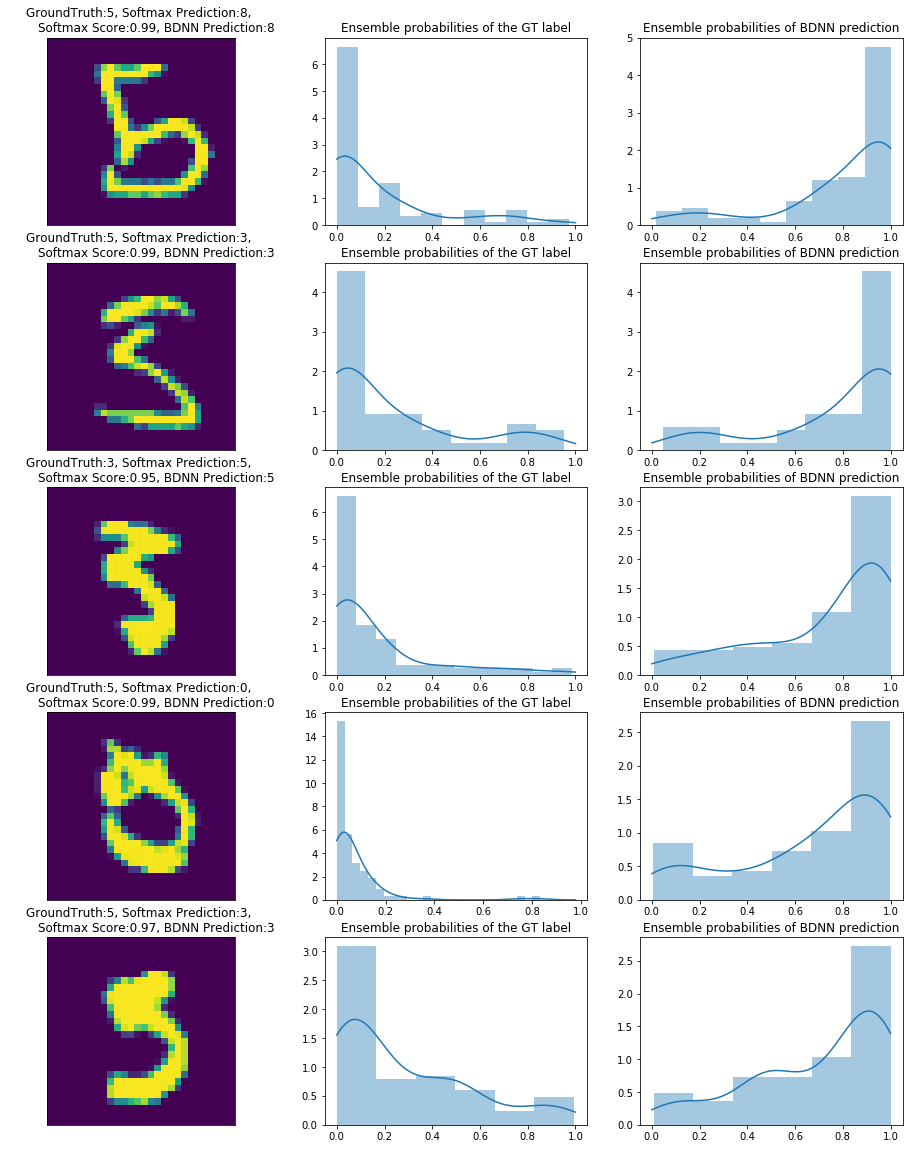

In [17]:
mlp_dropout.train()

ensemble_size = 100

number_of_rows = 5
idx = 0
fig, axes = plt.subplots(number_of_rows, 3, figsize=(16, 20 * number_of_rows // 5))
for it, test_batch in enumerate(wrong_subset_loader):
    images, target = test_batch
    if target.item() not in (3, 5):
        continue
    scores = []
    for _ in range(ensemble_size):
        test_data_batch = images.view(target.shape[0], 784)
        output_test = mlp_dropout(test_data_batch.to(device).float())
        scores.append(F.softmax(output_test, dim=1).data.numpy())
    scores = np.vstack(scores)
    label = scores.mean(axis=0).argmax(0)
    predictive_mean = np.round(np.mean(scores[:, label]), 2)
    predictive_std = np.round(np.std(scores[:, label]), 2)
    
    if wrong_samples_scores[it] > 0.95:
        img = images[0, 0].data.numpy()
        axes[idx, 0].imshow(img)
        axes[idx, 0].set_title(f"""GroundTruth:{target.item()}, Softmax Prediction:{wrong_samples_labels[it]}, 
        Softmax Score:{str(np.around(wrong_samples_scores[it], 2))}, BDNN Prediction:{label}""")
        axes[idx, 0].xaxis.set_visible(False)
        axes[idx, 0].yaxis.set_visible(False)
        axes[idx, 0].xaxis.set_ticks([])
        axes[idx, 0].yaxis.set_ticks([])
        sb.distplot(scores[:, target.item()], kde=True, kde_kws={'clip': (0.0, 1.0)}, ax=axes[idx, 1])
        axes[idx, 1].set_title(f"Ensemble probabilities of the GT label")
        sb.distplot(scores[:, label], kde=True, kde_kws={'clip': (0.0, 1.0)}, ax=axes[idx, 2])
        axes[idx, 2].set_title(f"Ensemble probabilities of BDNN prediction")
        idx += 1
    if idx == number_of_rows:
        break


### Compute the uncertainties for the correct results

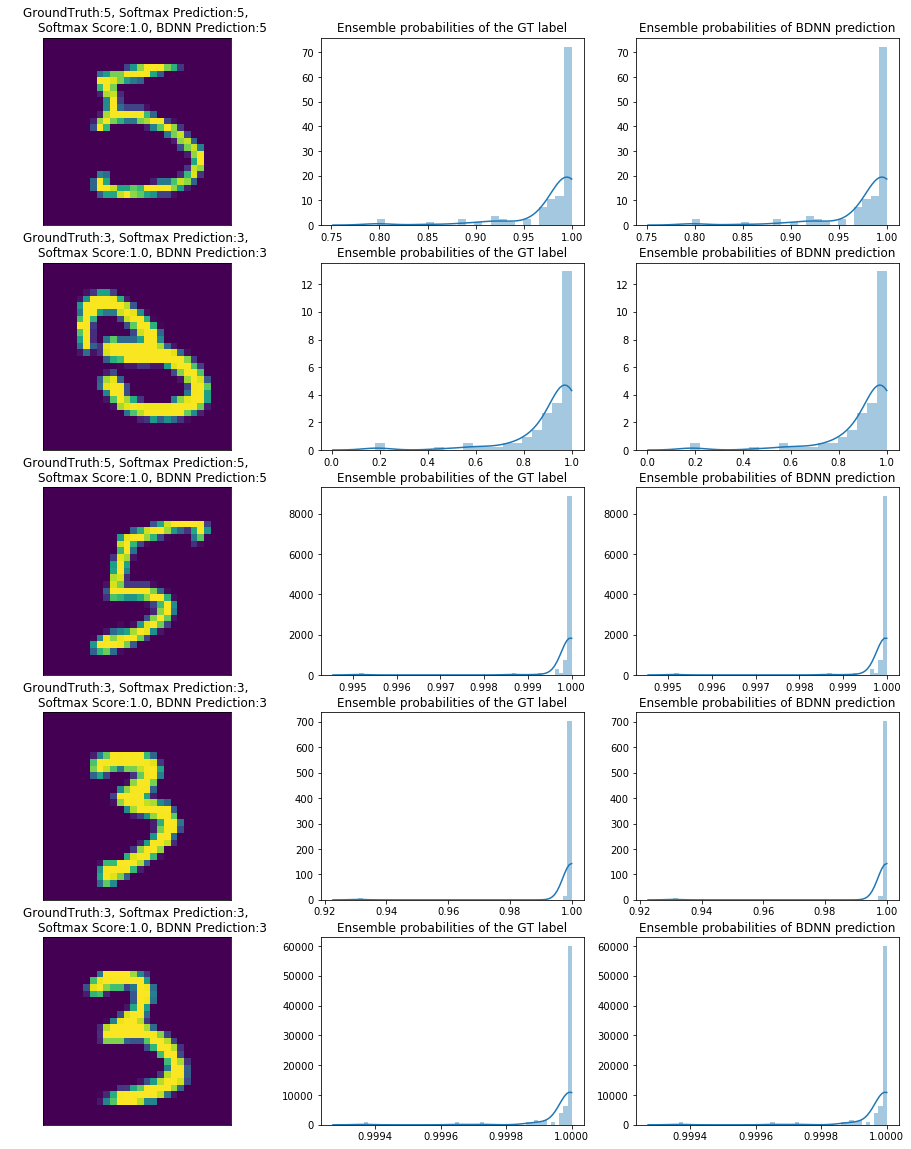

In [18]:
mlp_dropout.train()

ensemble_size = 100

number_of_rows = 5
idx = 0
fig, axes = plt.subplots(number_of_rows, 3, figsize=(16, 20 * number_of_rows // 5))
for it, test_batch in enumerate(right_subset_loader):
    images, target = test_batch
    if target.item() not in (3, 5):
        continue
    scores = []
    for _ in range(ensemble_size):
        test_data_batch = images.view(target.shape[0], 784)
        output_test = mlp_dropout(test_data_batch.to(device).float())
        scores.append(F.softmax(output_test, dim=1).data.numpy())
    scores = np.vstack(scores)
    label = scores.mean(axis=0).argmax(0)
    predictive_mean = np.round(np.mean(scores[:, label]), 2)
    predictive_std = np.round(np.std(scores[:, label]), 2)
    
    if right_samples_scores[it] > 0.95:
        img = images[0, 0].data.numpy()
        axes[idx, 0].imshow(img)
        axes[idx, 0].set_title(f"""GroundTruth:{target.item()}, Softmax Prediction:{right_samples_labels[it]}, 
        Softmax Score:{str(np.around(right_samples_scores[it], 2))}, BDNN Prediction:{label}""")
        axes[idx, 0].xaxis.set_visible(False)
        axes[idx, 0].yaxis.set_visible(False)
        axes[idx, 0].xaxis.set_ticks([])
        axes[idx, 0].yaxis.set_ticks([])
        sb.distplot(scores[:, target.item()], kde=True, kde_kws={'clip': (0.0, 1.0)}, ax=axes[idx, 1])
        axes[idx, 1].set_title(f"Ensemble probabilities of the GT label")
        sb.distplot(scores[:, label], kde=True, kde_kws={'clip': (0.0, 1.0)}, ax=axes[idx, 2])
        axes[idx, 2].set_title(f"Ensemble probabilities of BDNN prediction")
        idx += 1
    if idx == number_of_rows:
        break


## Test the MNIST model on Fashion-MNIST dataset

In [19]:
batch_size = 1
fmnist_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.28604105,), (0.35302445,))])
fmnist_train_dataset = torchvision.datasets.FashionMNIST('./data/', train=True, download=True, transform=fmnist_transform)
fmnist_train_loader = DataLoader(fmnist_train_dataset, batch_size=batch_size, shuffle=True)

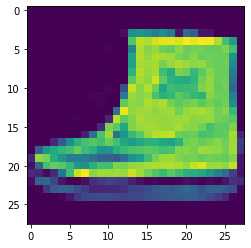

In [20]:
sample_data = next(enumerate(fmnist_train_loader))
sample_data = sample_data[1][0].view(batch_size, 784)[0, :].view(28, 28).data.numpy()
plt.imshow(sample_data)

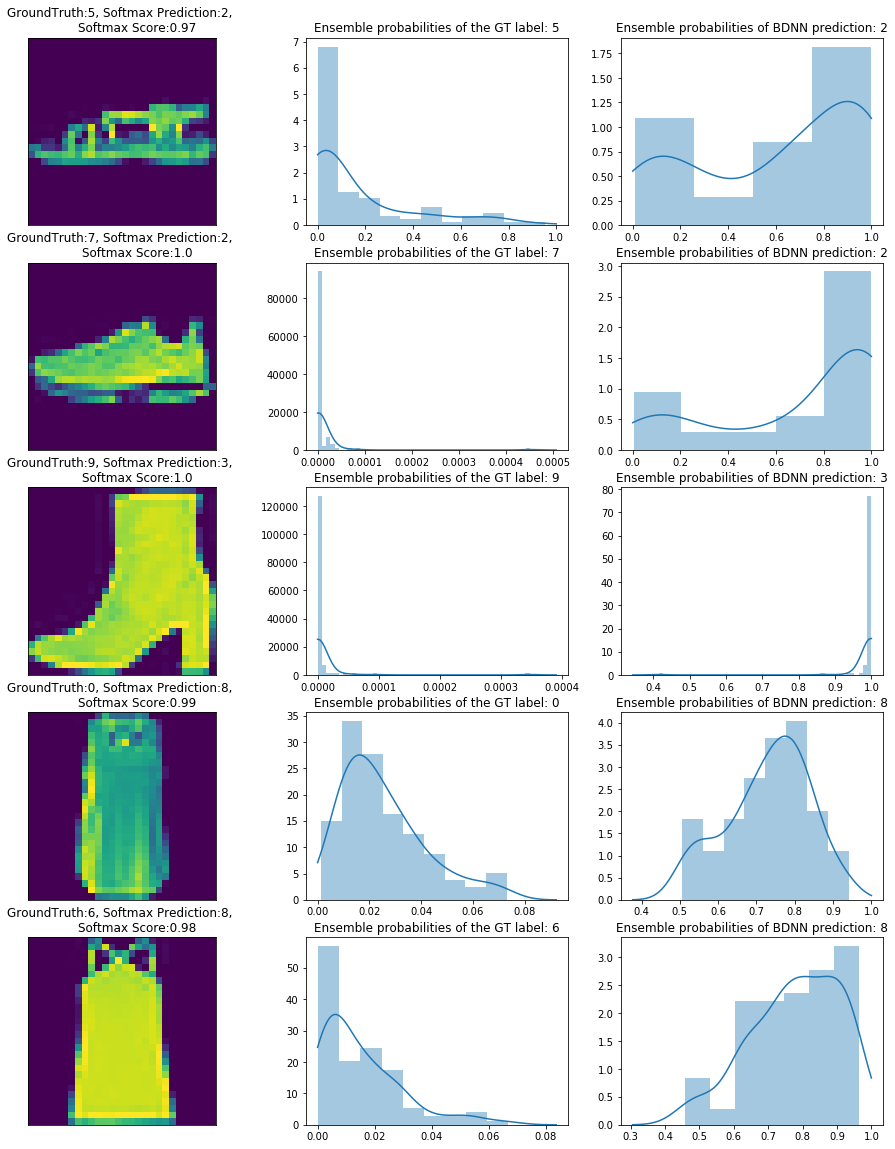

In [21]:
mlp_dropout.train()
mlp.eval()

ensemble_size = 100

number_of_rows = 5
idx = 0
fig, axes = plt.subplots(number_of_rows, 3, figsize=(16, 20 * number_of_rows // 5))
for it, test_batch in enumerate(fmnist_train_loader):
    images, target = test_batch
    
    scores = []
    for _ in range(ensemble_size):
        test_data_batch = images.view(target.shape[0], 784)
        output_test = mlp_dropout(test_data_batch.to(device).float())
        scores.append(F.softmax(output_test, dim=1).data.numpy())
    scores = np.vstack(scores)
    label = scores.mean(axis=0).argmax(0)
    
    test_data_batch = images.view(target.shape[0], 784)
    output_test_no_dropout = mlp(test_data_batch.to(device).float())
    preds_test_no_dropout = F.softmax(output_test_no_dropout, dim=1).data.numpy()[0]
    softmax_label = preds_test_no_dropout.argmax()
    softmax_score = preds_test_no_dropout.max()
    
    if softmax_score > 0.95:
        img = images[0, 0].data.numpy()
        axes[idx, 0].imshow(img)
        axes[idx, 0].set_title(f"""GroundTruth:{target.item()}, Softmax Prediction:{softmax_label}, 
        Softmax Score:{str(np.round(softmax_score, 2))}""")
        axes[idx, 0].xaxis.set_visible(False)
        axes[idx, 0].yaxis.set_visible(False)
        axes[idx, 0].xaxis.set_ticks([])
        axes[idx, 0].yaxis.set_ticks([])
        sb.distplot(scores[:, target.item()], kde=True, kde_kws={'clip': (0.0, 1.0)}, ax=axes[idx, 1])
        axes[idx, 1].set_title(f"Ensemble probabilities of the GT label: {target.item()}")
        sb.distplot(scores[:, label], kde=True, kde_kws={'clip': (0.0, 1.0)}, ax=axes[idx, 2])
        axes[idx, 2].set_title(f"Ensemble probabilities of BDNN prediction: {label}")
        idx += 1
    if idx == number_of_rows:
        break